In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
dataset_dir = '/content/drive/MyDrive/UAS PMDPM 2024/DATASET'
test_dir = '/content/drive/MyDrive/UAS PMDPM 2024/Test'

In [17]:
img_size = 180
batch_size = 32
validation_split = 0.1

dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    validation_split=validation_split,
    subset="training",
    interpolation="bilinear"
)

class_names = dataset.class_names
print("Nama Kelas:", class_names)

Found 269 files belonging to 3 classes.
Using 243 files for training.
Nama Kelas: ['Beras Hitam', 'Beras Merah', 'Beras Putih']


In [18]:
total_count = len(dataset)
val_count = int(total_count * validation_split)
train_count = total_count - val_count

train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)


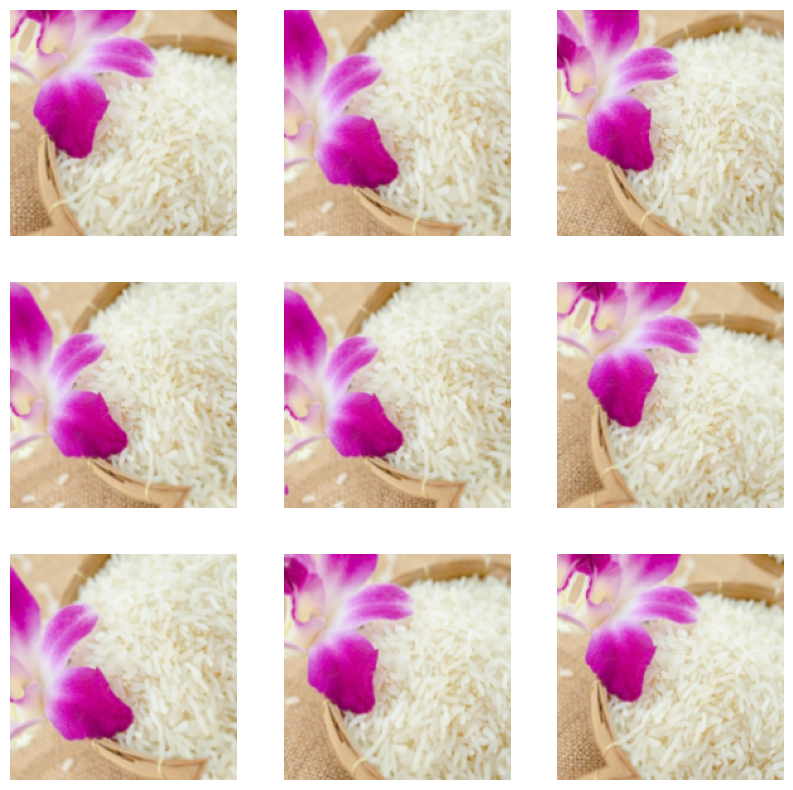

In [19]:
data_augmentation = Sequential([
    layers.RandomFlip("diagonal", input_shape=(img_size, img_size, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')
plt.show()


In [20]:
base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max')


history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stopping]
)



<ipython-input-20-d135df2c45a6>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.2985 - loss: 1.9274

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3019 - loss: 1.9087  
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 584ms/step - accuracy: 0.4879 - loss: 1.1843
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 542ms/step - accuracy: 0.5341 - loss: 1.0105
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 414ms/step - accuracy: 0.6575 - loss: 0.7569
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 555ms/step - accuracy: 0.7518 - loss: 0.6252
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 480ms/step - accuracy: 0.7398 - loss: 0.5907
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 403ms/step - accuracy: 0.7755 - loss: 0.4802
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 395ms/step - accuracy: 0.8495 - loss: 0.4521
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 560ms/step - accuracy: 0.9004 - loss: 0.3162
Epoch 10/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 487ms/step - accuracy: 0.8727 - loss: 0.3451
Epoch 11/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 403ms/step - accuracy: 0.8960 - loss: 0.2841
Epoch 12/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.9224 - loss: 0.2548
Epoch 13/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 476ms/step - accuracy: 0.9494 - loss: 0.2323

In [22]:
model.save('/content/drive/MyDrive/UAS PMDPM 2024/model_mobilenet.h5')


In [23]:
def classify_images(image_path, model, class_names):
    try:
        input_image = tf.keras.utils.load_img(image_path, target_size=(img_size, img_size))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)

        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Kepercayaan: {confidence:.2f}%")

        input_image = Image.open(image_path)
        input_image.save('/content/drive/MyDrive/UAS PMDPM 2024/Test/Hitam/images (39).jpg')

        return f"Prediksi: {class_names[class_idx]} dengan kepercayaan {confidence:.2f}%. Gambar disimpan."
    except Exception as e:
        return f"Error: {e}"


test_images = [
    '/content/drive/MyDrive/UAS PMDPM 2024/Test/Hitam/images (42).jpg',
    '/content/drive/MyDrive/UAS PMDPM 2024/Test/Merah/Image_86.jpg',
    '/content/drive/MyDrive/UAS PMDPM 2024/Test/Putih/images (32).jpg'
]

for img_path in test_images:
    result = classify_images(img_path, model, class_names)
    print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediksi: Beras Hitam
Kepercayaan: 40.64%
Prediksi: Beras Hitam dengan kepercayaan 40.64%. Gambar disimpan.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediksi: Beras Merah
Kepercayaan: 42.80%
Prediksi: Beras Merah dengan kepercayaan 42.80%. Gambar disimpan.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediksi: Beras Putih
Kepercayaan: 56.93%
Prediksi: Beras Putih dengan kepercayaan 56.93%. Gambar disimpan.


Found 30 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


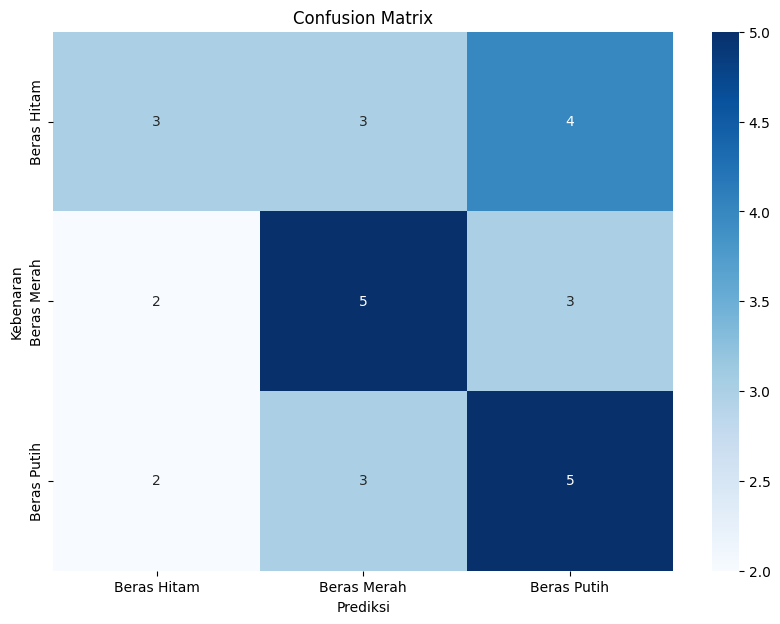

In [24]:

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_size, img_size)
)

y_pred = model.predict(test_data)
y_pred_class = np.argmax(y_pred, axis=1)

true_labels = []
for _, labels in test_data:
    true_labels.extend(np.argmax(labels, axis=1))

conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)
accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)
precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Kebenaran')
plt.title('Confusion Matrix')
plt.show()